In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [3]:
# 1. Load Dataset
df = pd.read_csv('/content/breast-cancer.csv')

In [4]:
# Inspect column names and choose features
print(df.head())
print(df.columns)

# Assume target column is named something like 'diagnosis' or 'target'
# Adjust as per actual column names
target_col = 'diagnosis' if 'diagnosis' in df.columns else df.columns[-1]

# Encode categorical labels if necessary
if df[target_col].dtype == 'object':
    le = LabelEncoder()
    df[target_col] = le.fit_transform(df[target_col])

X = df.drop(columns=[target_col])
y = df[target_col]

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [5]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [6]:
# 2. Train SVM (Linear Kernel)
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear.fit(X_train, y_train)


SVC(kernel='linear')

In [7]:
# 3. Train SVM (RBF Kernel)
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_rbf.fit(X_train, y_train)


SVC()

In [8]:
# 4. Decision Boundary Plot Function
def plot_decision_boundary(model, X, y, title):
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title(title)
    plt.show()


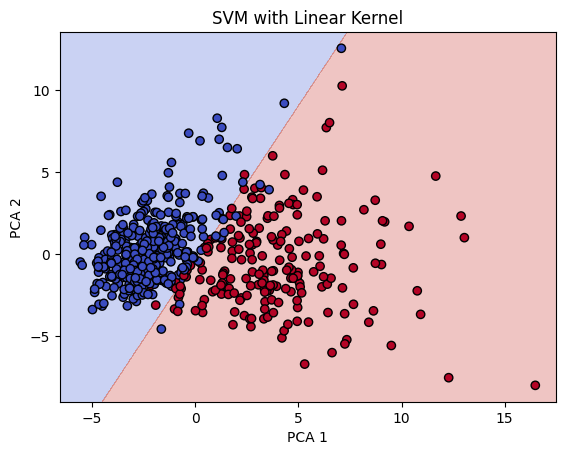

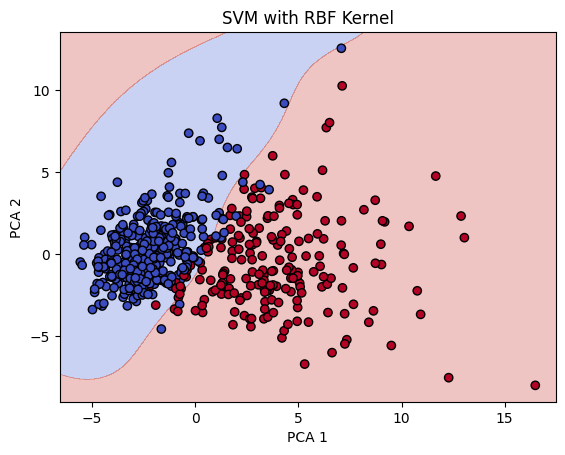

In [9]:
# Plot linear and RBF boundaries
plot_decision_boundary(svm_linear, X_pca, y, "SVM with Linear Kernel")
plot_decision_boundary(svm_rbf, X_pca, y, "SVM with RBF Kernel")


In [10]:
# 5. Hyperparameter Tuning (RBF)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best Parameters (RBF):", grid.best_params_)
print("Best CV Score:", grid.best_score_)


Best Parameters (RBF): {'C': 100, 'gamma': 0.001}
Best CV Score: 0.9362637362637363


In [11]:
# 6. Cross-validation Evaluation
svm_best = grid.best_estimator_
cv_scores = cross_val_score(svm_best, X_pca, y, cv=5)
print("Cross-Validation Accuracy (mean):", cv_scores.mean())


Cross-Validation Accuracy (mean): 0.9402732494954199


In [12]:
# Final Evaluation
y_pred = svm_best.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        71
           1       1.00      0.98      0.99        43

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

Confusion Matrix:
 [[71  0]
 [ 1 42]]


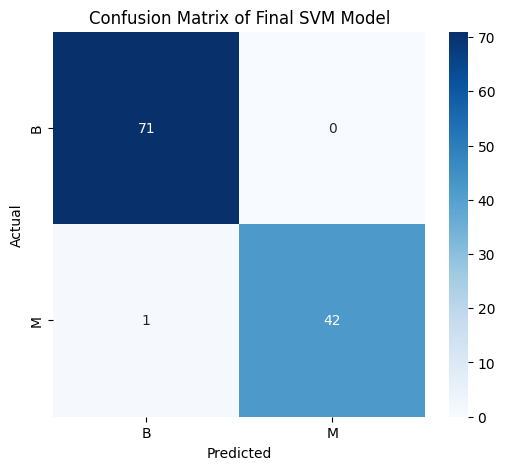

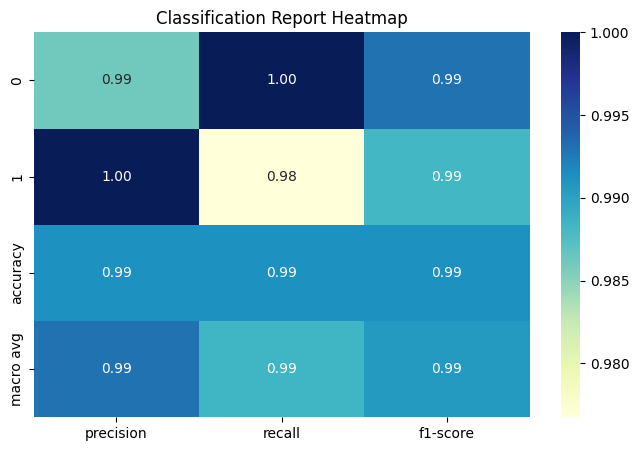

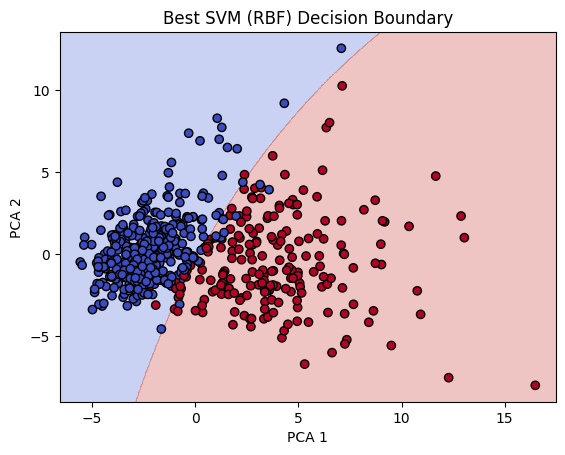

In [14]:
# --- 1. Confusion Matrix Plot ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_ if 'le' in locals() else ['Class 0', 'Class 1'],
            yticklabels=le.classes_ if 'le' in locals() else ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Final SVM Model')
plt.show()

# --- 2. Visualize Classification Report ---
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()

# --- 3. Optional: Plot Decision Boundary of Best SVM ---
plot_decision_boundary(svm_best, X_pca, y, "Best SVM (RBF) Decision Boundary")